### Ноут для экспериментов с обучением регрессора для симуляции движения динамического объекта

##### Система уравнений  
$\begin{cases} \dot{x}=(\alpha-\beta y)x \\ \dot{y}=(-\gamma+\delta x)y \end{cases}$

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

In [7]:
def system(t, y):
    a = 2/3
    b = 4/3
    g = 1
    d = 1
    return [
        (a - b * y[1]) * y[0],
        (-g + d * y[0]) * y[1]
    ]

In [3]:
def solve_equation(y0 = [0.9, 0.9], n=100):
    t0, t1 = 0, 100
    ts = np.linspace(t0, t1, n)

    return integrate.solve_ivp(fun=lambda t,y: system(t,y), t_span=[t0, t1], y0=y0, t_eval=ts, method='RK45')

In [4]:
def plot_solution(sol):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.ylabel(r'$x$', fontsize=16)
    plt.xlabel(r'$t$', fontsize=16)
    plt.plot(sol.t, sol.y[0])
    plt.subplot(2, 1, 2)
    plt.ylabel(r'$y$', fontsize=16)
    plt.xlabel(r'$t$', fontsize=16)
    plt.plot(sol.t, sol.y[1])
    plt.show()

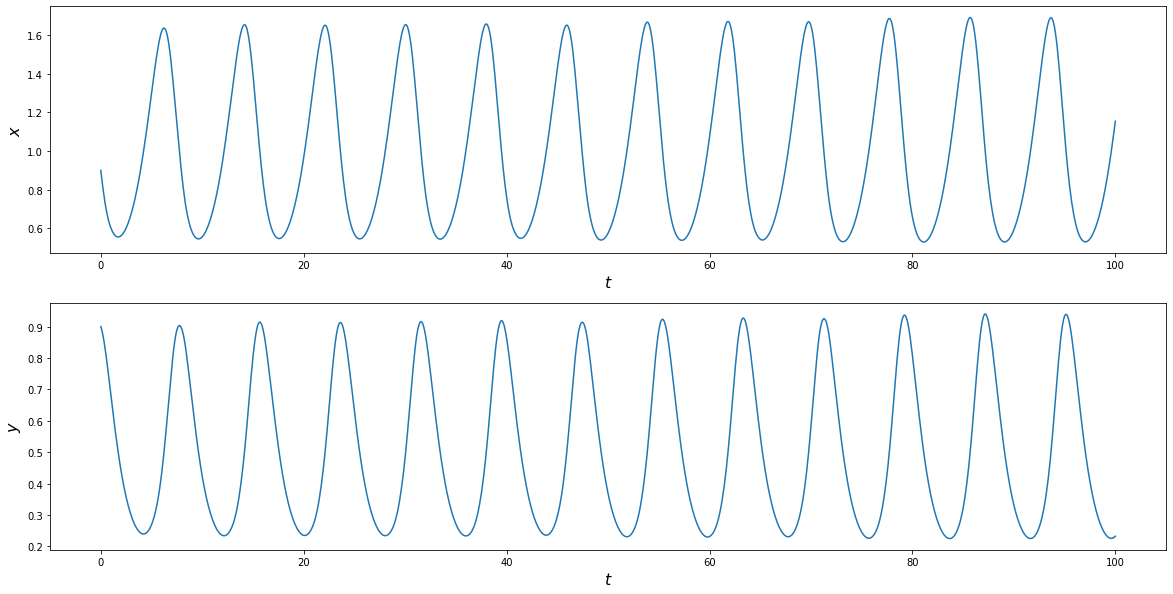

In [9]:
sol = solve_equation(y0 = [0.9, 0.9], n = 1000)
plot_solution(sol)

### На основе симуляции подбираем модель для индентификации системы

In [14]:
def sol_to_df(sol):
    df = pd.DataFrame({'t': sol.t, 'x': sol.y[0], 'y': sol.y[1]})
    df = df.assign(
        t_next=df.t.shift(-1),
        x_next=df.x.shift(-1),
        y_next=df.y.shift(-1)
    )
    df = df.iloc[:-1]
    return df

##### Готовим обучающую выборку

In [41]:
all_df = []
for x in np.linspace(0.1, 5, num=10):
    for y in np.linspace(0.1, 5, num=5):
        sol = solve_equation(y0 = [x, y], n=1500)
        df = sol_to_df(sol)
        all_df.append(df)
for x in np.linspace(0.1, 5, num=4):
    for y in np.linspace(0.1, 5, num=7):
        sol = solve_equation(y0 = [x, y], n=1000)
        df = sol_to_df(sol)
        all_df.append(df)
df = pd.concat(all_df)
df.head()

,t,x,y,t_next,x_next,y_next
0,0.000000,0.100000,0.100000,0.066711,0.103649,0.094184
1,0.066711,0.103649,0.094184,0.133422,0.107485,0.088728
2,0.133422,0.107485,0.088728,0.200133,0.111515,0.083606
3,0.200133,0.111515,0.083606,0.266845,0.115748,0.078797
4,0.266845,0.115748,0.078797,0.333556,0.120190,0.074286


In [49]:
X = df[['t','x','y','t_next']]
Y = df[['x_next', 'y_next']]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

72045 30877


In [50]:
#{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
regr = MLPRegressor(
    activation="tanh",
    alpha=0.05,
    hidden_layer_sizes=(100, 50, 30),
    learning_rate="constant",
    max_iter=100,
    solver="adam"
).fit(X_train, Y_train)
regr.predict(X_test)
regr.score(X_test, Y_test)

0.9991428698921045

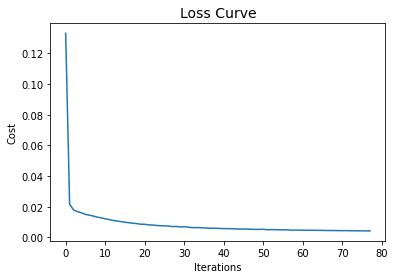

In [51]:
plt.plot(regr.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [52]:
def plot_compare(sol1, sol2):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.ylabel(r'$x$', fontsize=16)
    plt.xlabel(r'$t$', fontsize=16)
    plt.plot(sol1.t, sol1.y[0], color='b', label='ode')
    plt.plot(sol2.t, sol2.y[0], color='r', label='regr')
    plt.subplot(2, 1, 2)
    plt.ylabel(r'$y$', fontsize=16)
    plt.xlabel(r'$t$', fontsize=16)
    plt.plot(sol1.t, sol1.y[1], color='b', label='ode')
    plt.plot(sol2.t, sol2.y[1], color='r', label='regr')
    plt.show()

In [53]:
def build_df(t,y,t_next):
    return [[t,y[0],y[1],t_next]]
# return pd.DataFrame({'t':[t],'phi':[y[0]],'psi':[y[1]],'c':[c],'t_next':[t_next]})

In [54]:
class Sol:
    
    def __init__(self, t, y):
        self.t = t
        self.y = y

def model(regr, y0 = [0.9, 0.9], n=100):
    t0, t1 = 0, 100
    ts = np.linspace(t0, t1, n)
    
    res_t = []
    res_x = []
    res_y = []
    
    t = ts[0]
    x = y0[0]
    y = y0[1]
    
    for t_next in ts[1:]:
        
        res_t.append(t)
        res_x.append(x)
        res_y.append(y)
        current = build_df(t,[x,y],t_next)
        nxt = regr.predict(current)
        t = t_next
        x = nxt[0][0]
        y = nxt[0][1]
        
    return Sol(res_t, [res_x, res_y])

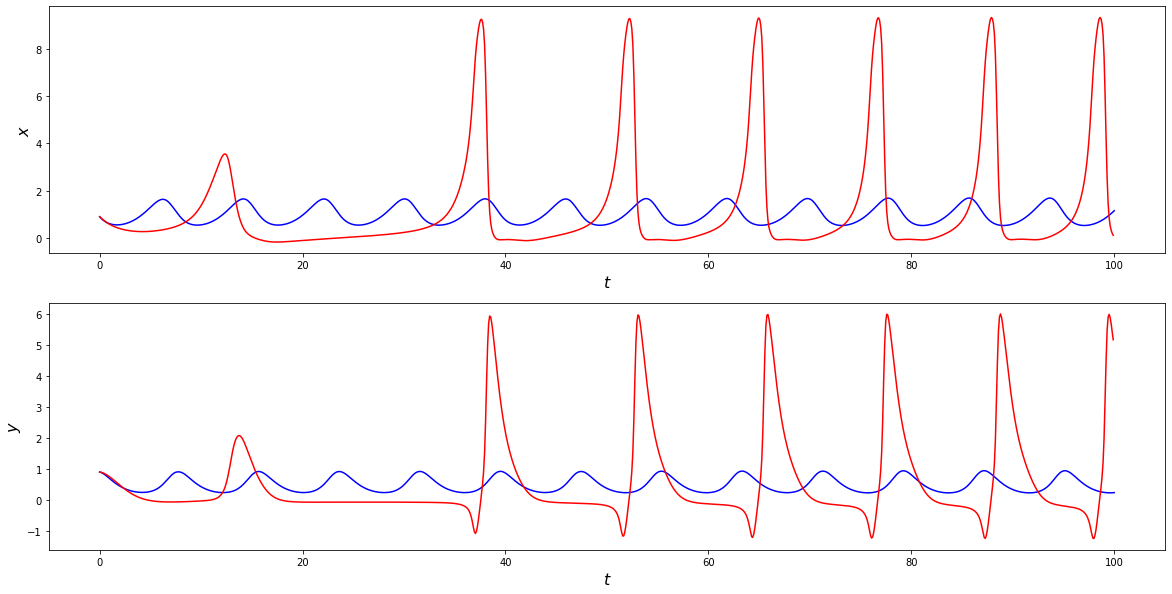

In [55]:
import warnings
warnings.filterwarnings("ignore")
sol = solve_equation(y0=[0.9, 0.9], n=1000)
sol_regr = model(regr, y0=[0.9, 0.9], n=1000)
plot_compare(sol, sol_regr)

In [46]:
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

#{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}

In [47]:
grid = GridSearchCV(regr, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train, Y_train)

print(grid.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
